# Finite difference method: Poisson equation in 2D

Consider the following problem:
$$
\left\{
\begin{aligned}
- \Delta u &= f \;  &\quad \text{in } \Omega = (0,1)^2 \\
u &= g \;  &\quad \text{on } \partial \Omega 
\end{aligned}
\right.
$$
The function $f$ and $g$ are chosen, such that
$$
u(x,y) = x(1-x)y(1-y) e^{2(x+y)} \; .
$$
is the solution of the problem. 

For the discretization use the five-point stencil. The grid with $N$ inner points should be numerated in a lexigraphic order. Plot the exact and numerical solution for $N = 10, 20, 40, 80$ inner points. Plot the error $\max_i |u(x_i) - u_h(x_i)|$ w.r.t. the mesh size $h$ on a log-log scale.

## Solution

We calculate
$$
\Delta u(x,y) = 2 (2x^2 + 2x - 1) (y-1) y e^{2(x+y)} + 2 (x-1)x(2y^2 + 2y - 1)e^{(2(x+y)}
$$
so 
$$
f(x,y) = -2 (2x^2 + 2x - 1) (y-1) y e^{2(x+y)} - 2 (x-1)x(2y^2 + 2y - 1)e^{(2(x+y)} .
$$
We see that $g = 0$ on $\partial \Omega$.

In [1]:
f(x,y) = -2 * (2*x.^2 + 2*x .- 1) .* (y .- 1) .* y .* exp.(2 * (x+y)) - 2 * (x .- 1) .* x .* (2 * y.^2 + 2*y .- 1) .* exp.(2 * (x+y))

f (generic function with 1 method)

In [2]:
using SparseArrays
function solve_fd_poisson_2d(N, f)
    x = range(0, stop=1, length=N+2)
    y = range(0, stop=1, length=N+2)
    indices = collect(Iterators.product(x[2:end-1], y[2:end-1]))[:]
    xarr = [i for (i,j) in indices]
    yarr = [j for (i,j) in indices]
    f_vec = f(xarr, yarr)
    
    mdiag = 4 * ones(N^2)
    udiag = -1 * ones(N^2-1)
    ldiag = -1 * ones(N^2-1)
    uudiag = -1 * ones(N^2 - N)
    lldiag = -1 * ones(N^2 - N)
    for i = N:N:N^2-1
        udiag[i] = 0
        ldiag[i] = 0
    end
    M = spdiagm(-N => lldiag, -1 => ldiag, 0 => mdiag, 1 => udiag, N => uudiag)
    h = 1 / (N+1)
    rhs = h^2 * f_vec
    u_inner = M \ rhs
    u = zeros((N + 2)^2)
    
    loc = 1
    glc = 1
    for (i, j) in Iterators.product(x, y)
        if (i > 0.0) && (i < 1.0) && (j > 0.0) && (j < 1.0)
            u[glc] = u_inner[loc]
            loc += 1
        end
        glc += 1
    end
return u
end

solve_fd_poisson_2d (generic function with 1 method)

In [3]:
function exact_solution(N, f)
    u(x,y) = x .* (1 .- x) .* y .* (1 .- y) .* exp.(2*(x+y))
    x = range(0, stop=1, length=N+2)
    y = range(0, stop=1, length=N+2)
    indices = collect(Iterators.product(x, y))[:]
    xarr = [i for (i,j) in indices]
    yarr = [j for (i,j) in indices]
    u(xarr, yarr)
end

exact_solution (generic function with 1 method)

Let's calculate the numerical and exact solution for $N = 10, 20, 40, 80$ inner points and evaluate the error.

In [4]:
n_inner_points = [10, 20, 40, 80]
mesh_sizes = [1/(n+1) for n in n_inner_points]
xspaces = [range(0, stop=1, length=n+2) for n in n_inner_points]
yspaces = [range(0, stop=1, length=n+2) for n in n_inner_points]
exact_solutions = [exact_solution(n, f) for n in n_inner_points]
numerical_solutions = [solve_fd_poisson_2d(n, f) for n in n_inner_points]
errors = [maximum(abs, ex - num) for (ex, num) in zip(exact_solutions, numerical_solutions)]

4-element Array{Float64,1}:
 0.010797783156548446  
 0.0029712861891683096 
 0.000781407143948254  
 0.00020031769227413232

We write a function to plot the solution.

In [5]:
using PyPlot
function plot_solution(numsol, exsol, x, y)
    n = convert(Int, floor(sqrt(length(numsol))) - 2)

    xgrid = repeat(x', n+2, 1)
    ygrid = repeat(y, 1, n+2)
    znum = reshape(numsol, n+2, n+2)'
    zex = reshape(exsol, n+2, n+2)'
    
    
    fig = figure("pyplot_surfaceplot",figsize=(10,10))
    suptitle(string("Numerical and exact solution for ", n, " inner points"))
    
    for i = 1:2
        if i == 1
            subplot(221)
            tit = "Numerical solution 3D"
            z = znum
            sub = 1
        else
            subplot(222)
            tit = "Exact solution 3D"
            z = zex
            sub = 2
        end
        PyPlot.using3D()
        ax = fig.add_subplot(2, 2, sub, projection="3d")
        ax.plot_surface(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("jet"), alpha=0.8, linewidth=0.25)
        title(tit)
        xlabel("x")
        ylabel("y")
    end
    
    for i = 1:2
        if i == 1
            subplot(223)
            tit = "Numerical solution contour"
            z = znum
            sub = 3
        else
            subplot(224)
            tit = "Exact solution contour"
            z = zex
            sub = 4
        end
        ax = fig.add_subplot(2,2,sub)
        cp = ax.contour(xgrid, ygrid, z, colors="black", linewidth=2.0)
        ax.clabel(cp, inline=1, fontsize=10)
        xlabel("x")
        ylabel("y")
        title(tit)
    end
    
    tight_layout()
end

plot_solution (generic function with 1 method)

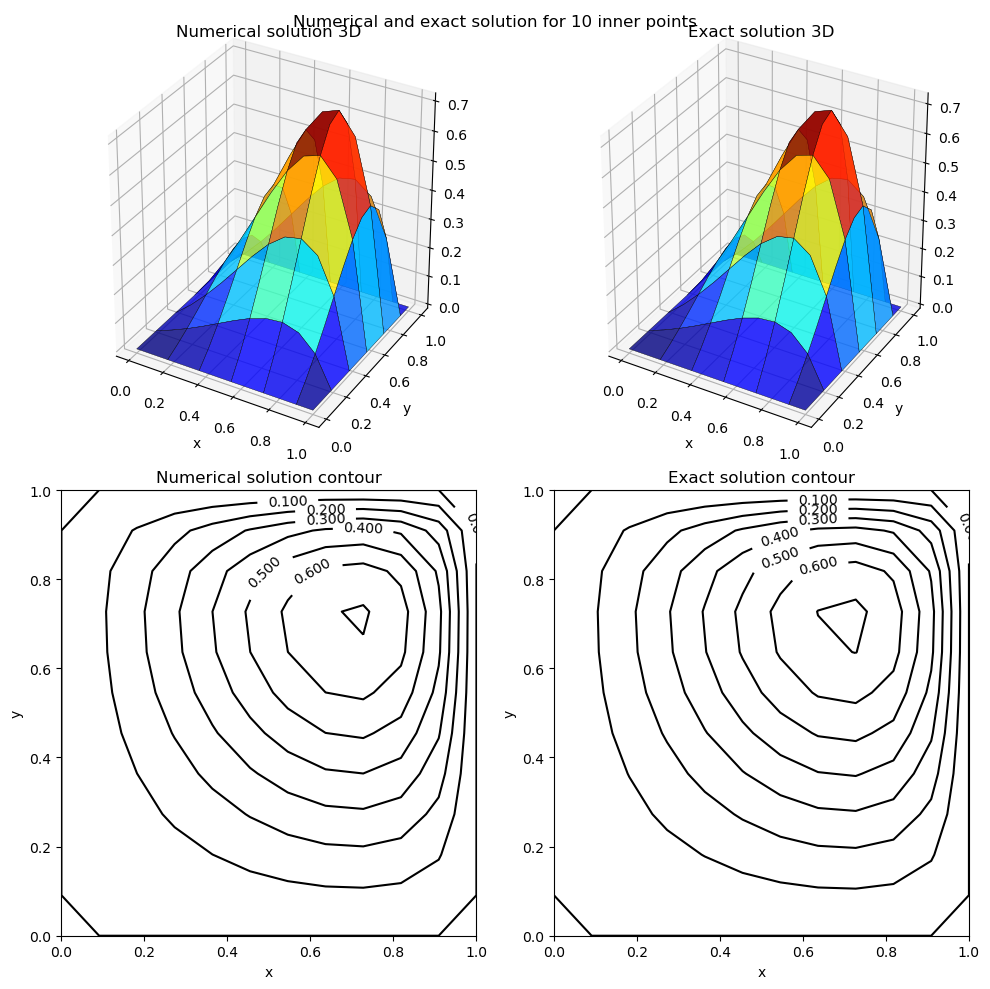

In [6]:
plot_solution(numerical_solutions[1], exact_solutions[1], xspaces[1], yspaces[1])

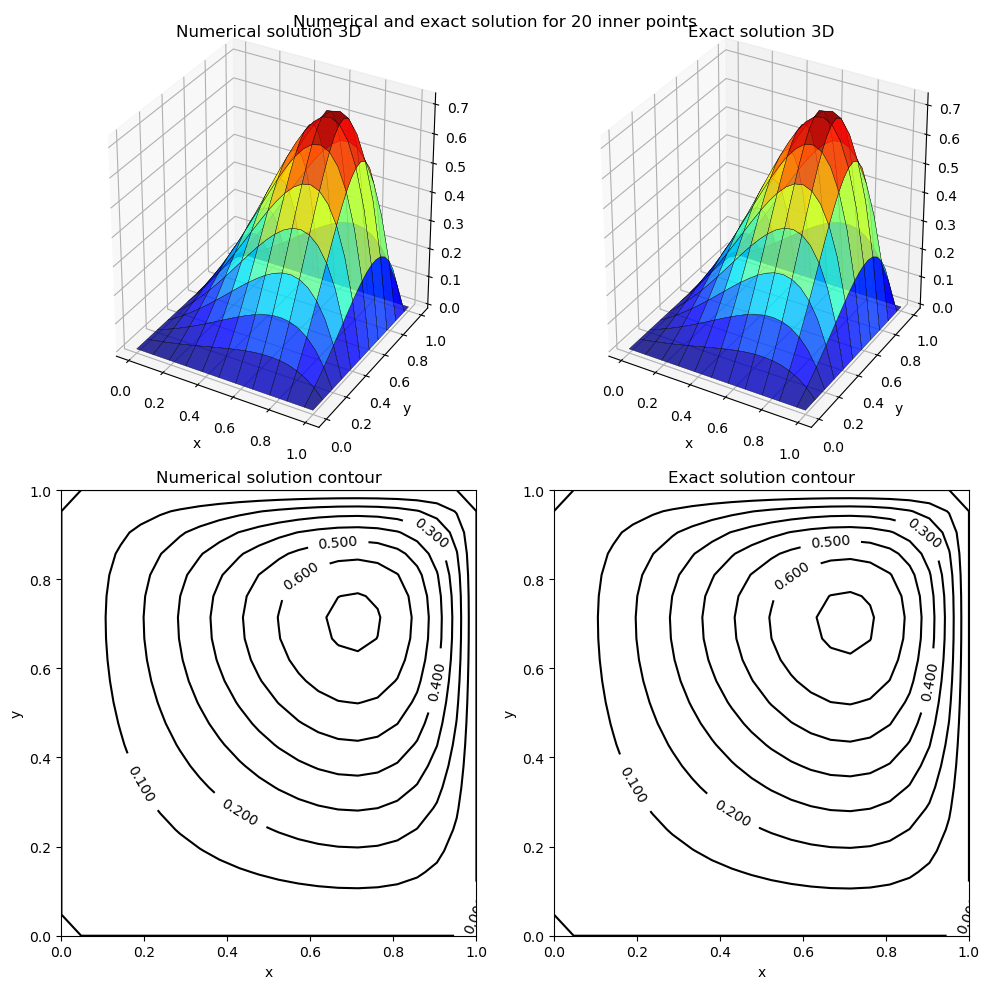

In [7]:
plot_solution(numerical_solutions[2], exact_solutions[2], xspaces[2], yspaces[2])

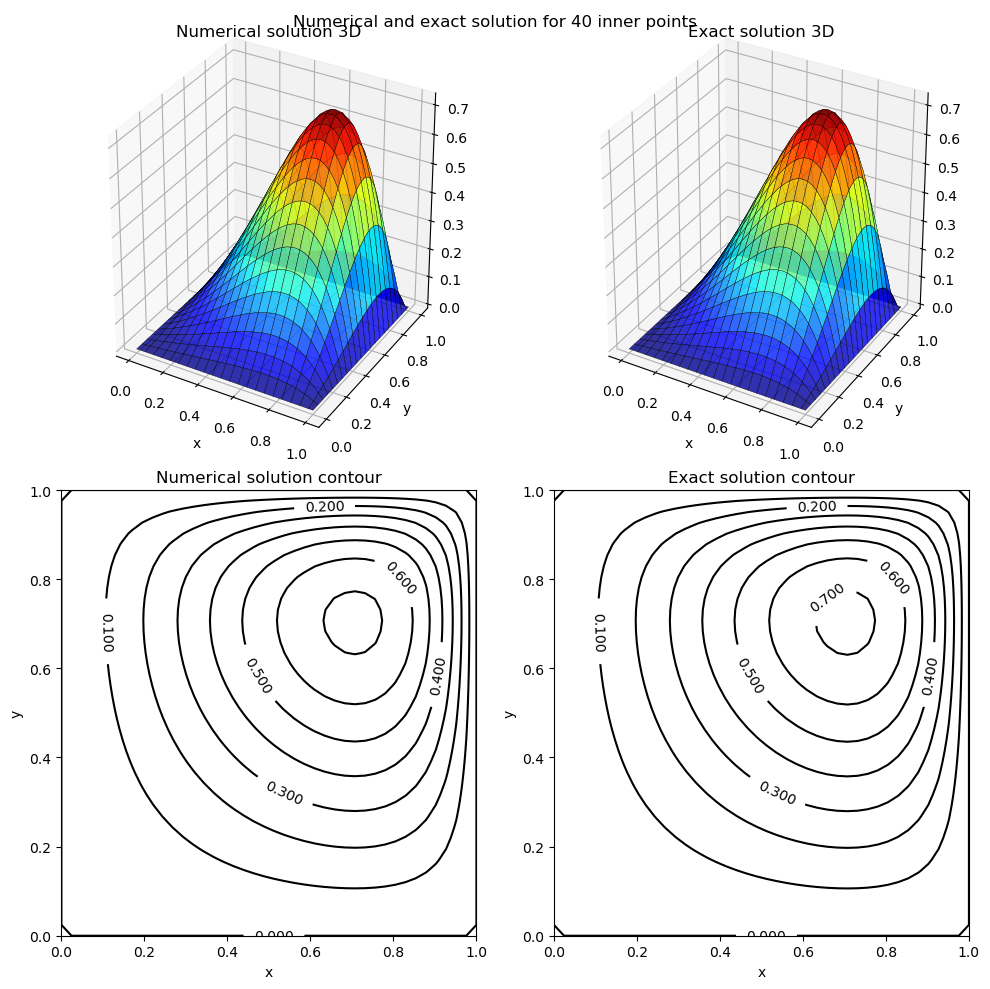

In [8]:
plot_solution(numerical_solutions[3], exact_solutions[3], xspaces[3], yspaces[3])

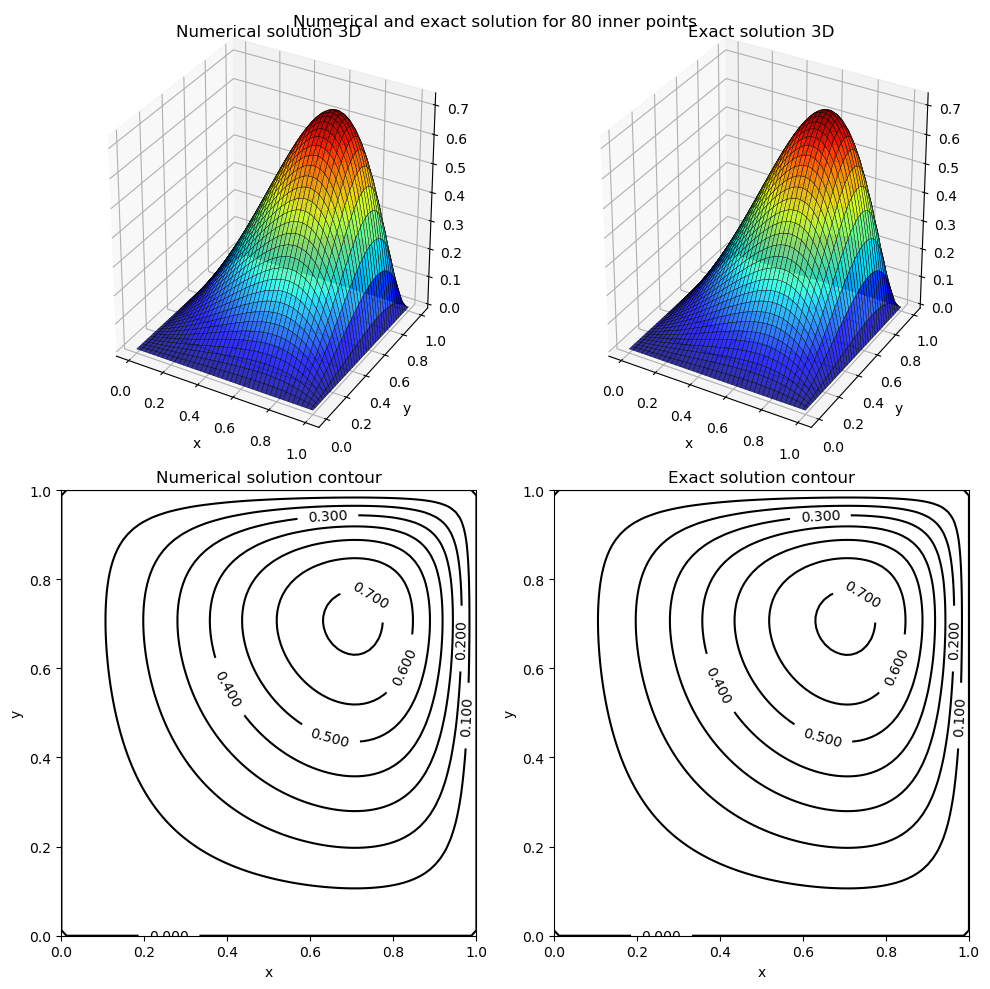

In [9]:
plot_solution(numerical_solutions[4], exact_solutions[4], xspaces[4], yspaces[4])

Finally, we plot the error w.r.t. the mesh size.

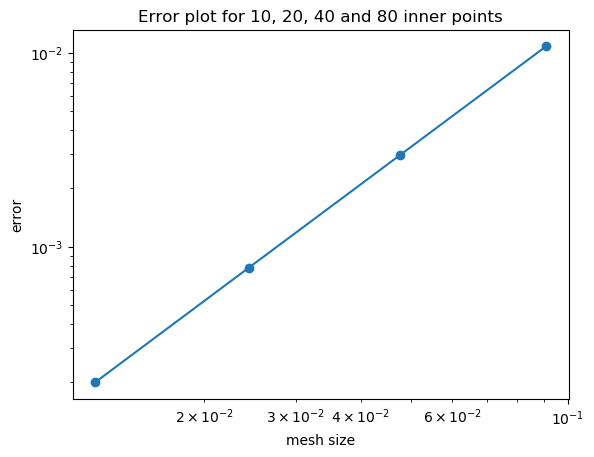

PyObject Text(24.000000000000007, 0.5, 'error')

In [10]:
loglog(mesh_sizes, errors, "-o")
title("Error plot for 10, 20, 40 and 80 inner points")
xlabel("mesh size")
ylabel("error")